In [1]:
from tkinter import Y

import numpy as np
from skimage import filters
import csv
import os

import matplotlib.pyplot as plt

In [2]:
loc = 'data/new/1304_2d/c5+.csv'

def show_image(image, title):
    # Show Image
    fig, ax = plt.subplots()
    ax.imshow(image, interpolation = 'nearest')
    ax.set_title(f'{title} image')
    fig.set_size_inches([2,2])

def csv_to_image(path):
    # Read in data
    with open(path, newline='\n') as c_file:
        reader = csv.reader(c_file, delimiter=',')
        reader.__next__()       # Skip column definitions

        pixels = [] 

        for row in reader:
            x, y, pixel = int(row[1]), int(row[2]), int(row[3])
            pixels.append((x, y, pixel))    # Store pixel as tuple

    # Get Bounds 
    x_min = min([pixel[0] for pixel in pixels])
    x_max = max([pixel[0] for pixel in pixels])
    y_min = min([pixel[1] for pixel in pixels])
    y_max = max([pixel[1] for pixel in pixels])

    # Generate Numpy Array
    image = np.empty([y_max-y_min+1, x_max-x_min+1])

    for pixel in pixels:
        image[pixel[1] - y_min, pixel[0] - x_min] = pixel[2]

    # Show Image
    show_image(image, path)

    return image



In [3]:
def norm_background(image, title, threshold = 0.75, hard = False, method = 0, processing = False):
    """
    ### Normalize Background
    Returns imaged normalized with respect to background. Method employed is specified by the `method` attribute, which defaults to `0`.
    #### Methods
    - `0` | Everything under `threshold` percentage of the maximum pixel value is background. \n
    \t The `hard` attribute here refers to whether we normalize against the background or do that *and* set the background to zero.
    - `1` | Otsu Thresholding
    """

    # PROCESSING
    if (processing):
        pixl_mean, pixl_std = np.mean(image), np.std(image)
        pixl_shift = pixl_mean + pixl_std
        # Set pixels above shift to mean
        image[image > pixl_shift] = 0

    norm_image = 0

    # 0) SIMPLE THRESHOLD
    if(method == 0):
        max_val = np.max(image)
        threshold = int(threshold * max_val)

    # 1) OTSU
    elif(method == 1):
        threshold = filters.threshold_otsu(image)

    # Make Threshold image
    image_threshold = np.copy(image)
    image_threshold[image_threshold > threshold] = 255
    image_threshold[image_threshold <= threshold] = 0

    show_image(image_threshold, f'THRESHOLD: {title}')

    # Find Background Mean Value    
    bg_indices = np.where(image_threshold == 0)     # Fetch Indices
    avg_bg_value = np.average(image[bg_indices])

    print(f'Background avg: {avg_bg_value} for {title}')

    # Normalize against background
    norm_image = (image - avg_bg_value).astype(int)
    norm_image = np.clip(norm_image, 0, 255)

    foreground_indices = np.where(image_threshold != 0)
    avg_foreground_value = np.average(image[foreground_indices])

    print(f'Foreground avg: {avg_foreground_value} for {title}')

    if hard:
        norm_image[bg_indices] = 0

    return norm_image


In [4]:
def integrate_image(image):
    cum_sum = np.sum(image)
    return cum_sum

In [5]:
def integral_analysis(path_band, path_loading, threshold = 0.75, hard = False, method = 0, processing = False):
    # 1) Obtain Normalized Images
    band_image = csv_to_image(path_band)
    band_norm = norm_background(band_image, path_band, threshold, hard, method, processing)

    show_image(band_norm, 'PROCESSED (BAND): ' + path_band)

    load_norm = 1
    # When there is loading control
    if os.path.exists(path_loading):
        load_image = csv_to_image(path_loading)
        load_norm = norm_background(load_image, path_loading, threshold, hard, method, processing)
        show_image(load_norm, 'PROCESSED (NORM): ' + path_loading)

    # 2) Integrate
    int_band, int_load = integrate_image(band_norm), integrate_image(load_norm)

    # Enrichment
    norm_magnitude = int_band / int_load
    if os.path.exists(path_loading):
        print(f'Magnitude (normalized): {norm_magnitude}')
        print(f'Magnitude (absolute, loading): {int_load}')
        print(f'Magnitude (absolute): {int_band}')
    else:
        print(f'Magnitude (absolute): {norm_magnitude}')
    return norm_magnitude

In [6]:
def enrichment_analysis(rel_path, suffix, title, threshold = 0.75, hard = False, method = 0, processing = False):
    rp, sf, ex = rel_path, suffix, '.csv'
    p, pn = rp + '/' + sf + '+' + ex, rp + '/' + sf + '+n' + ex
    n, nn = rp + '/' + sf + '-' + ex, rp + '/' + sf + '-n' + ex

    pos_magnitude = integral_analysis(p, pn, threshold, hard, method, processing)
    neg_magnitude = integral_analysis(n, nn, threshold, hard, method, processing)

    enrichment = pos_magnitude / neg_magnitude

    print(f'Enrichment of {title}: {enrichment}')

### 13/04 ASSAY
#### Assay Description
Cell line samples (lysate) were thawed from -80 degrees and prepared for a Western. The running was done at 50/100V and blotting at 30 mA overnight. 
#### Notes
- GAPDH was used as the loading control.

Background avg: 27.00442198357549 for data/new/1304_2d/c5+.csv
Foreground avg: 228.0808823529412 for data/new/1304_2d/c5+.csv
Background avg: 28.371895202449814 for data/new/1304_2d/c5+n.csv
Foreground avg: 227.75226977950715 for data/new/1304_2d/c5+n.csv
Magnitude (normalized): 0.7298641731847288
Magnitude (absolute, loading): 180524
Magnitude (absolute): 131758
Background avg: 22.655141310883945 for data/new/1304_2d/c5-.csv
Foreground avg: 149.07291666666666 for data/new/1304_2d/c5-.csv
Background avg: 19.03193171040152 for data/new/1304_2d/c5-n.csv
Foreground avg: 208.59780621572213 for data/new/1304_2d/c5-n.csv
Magnitude (normalized): 0.5113967547951475
Magnitude (absolute, loading): 124553
Magnitude (absolute): 63696
Enrichment of c5: 1.4271975063218654


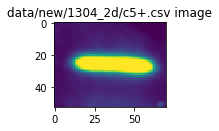

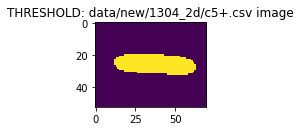

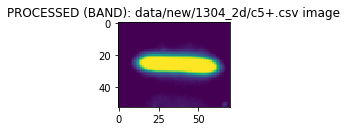

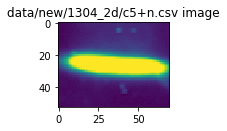

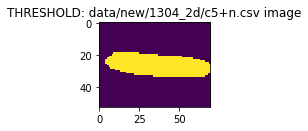

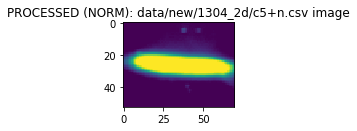

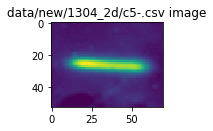

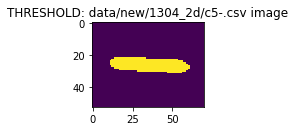

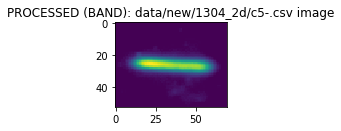

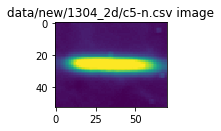

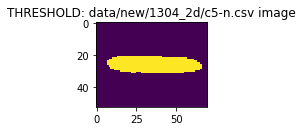

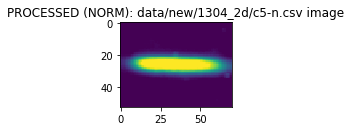

In [47]:
enrichment_analysis('data/new/1304_2d', 'c5', 'c5', threshold = 0.75, hard = False, method = 1)

Background avg: 37.62915064662705 for data/new/1304_2d/c4+.csv
Foreground avg: 237.434628975265 for data/new/1304_2d/c4+.csv
Background avg: 40.148017275225754 for data/new/1304_2d/c4+n.csv
Foreground avg: 238.37145313843507 for data/new/1304_2d/c4+n.csv
Magnitude (normalized): 0.7686243472458235
Magnitude (absolute, loading): 257754
Magnitude (absolute): 198116
Background avg: 22.188519447929735 for data/new/1304_2d/c4-.csv
Foreground avg: 229.13409961685824 for data/new/1304_2d/c4-.csv
Background avg: 34.62678260869565 for data/new/1304_2d/c4-n.csv
Foreground avg: 229.92814371257484 for data/new/1304_2d/c4-n.csv
Magnitude (normalized): 0.7158398747479947
Magnitude (absolute, loading): 186504
Magnitude (absolute): 133507
Enrichment of c4: 1.0737378209287534


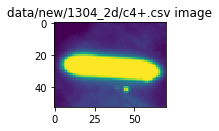

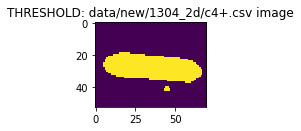

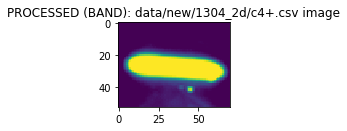

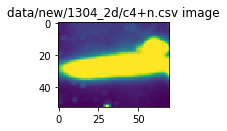

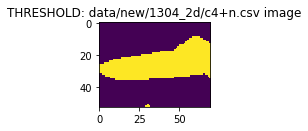

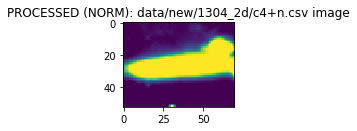

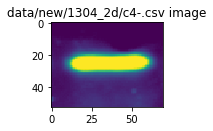

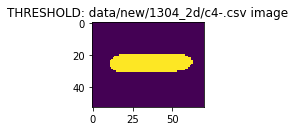

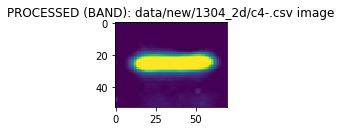

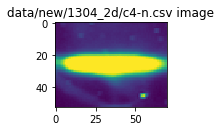

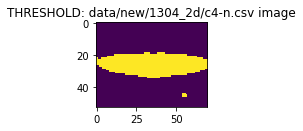

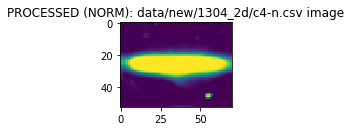

In [48]:
enrichment_analysis('data/new/1304_2d', 'c4', 'c4', threshold = 0.75, hard = False, method = 1)

Background avg: 32.020372010628876 for data/new/1304_2d/wt+.csv
Foreground avg: 165.55108359133126 for data/new/1304_2d/wt+.csv
Background avg: 23.32097675786996 for data/new/1304_2d/wt+n.csv
Foreground avg: 126.2282958199357 for data/new/1304_2d/wt+n.csv
Magnitude (normalized): 1.3466486333469632
Magnitude (absolute, loading): 31793
Magnitude (absolute): 42814
Background avg: 18.643371325734854 for data/new/1304_2d/wt-.csv
Foreground avg: 202.45478723404256 for data/new/1304_2d/wt-.csv
Background avg: 24.541826309067687 for data/new/1304_2d/wt-n.csv
Foreground avg: 221.14878892733563 for data/new/1304_2d/wt-n.csv
Magnitude (normalized): 0.6084199199110907
Magnitude (absolute, loading): 113374
Magnitude (absolute): 68979
Enrichment of wt: 2.2133539505803013


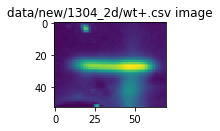

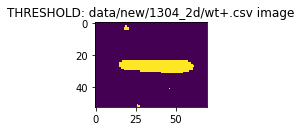

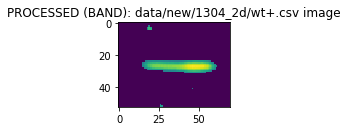

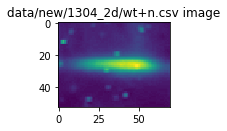

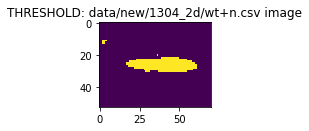

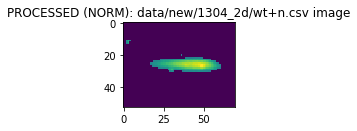

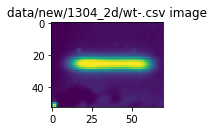

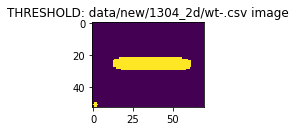

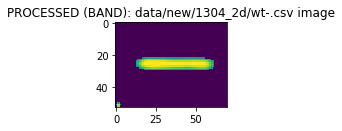

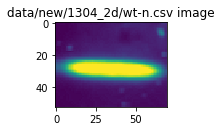

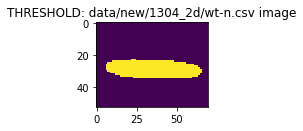

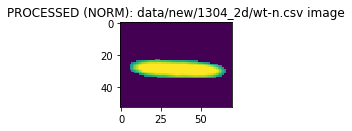

In [49]:
enrichment_analysis('data/new/1304_2d', 'wt', 'wt', threshold = 0.5, hard = True)

Background avg: 17.168564199873497 for data/new/1304_2d/hp+.csv
Foreground avg: 226.22262773722628 for data/new/1304_2d/hp+.csv
Background avg: 17.162589928057553 for data/new/1304_2d/hp+n.csv
Foreground avg: 225.6720430107527 for data/new/1304_2d/hp+n.csv
Magnitude (normalized): 0.5908095373702332
Magnitude (absolute, loading): 193135
Magnitude (absolute): 114106
Background avg: 8.920858895705521 for data/new/1304_2d/hp-.csv
Foreground avg: 156.7511111111111 for data/new/1304_2d/hp-.csv
Background avg: 9.838678010471204 for data/new/1304_2d/hp-n.csv
Foreground avg: 209.43119266055047 for data/new/1304_2d/hp-n.csv
Magnitude (normalized): 0.5097678412610789
Magnitude (absolute, loading): 130428
Magnitude (absolute): 66488
Enrichment of hp: 1.1589776552178557


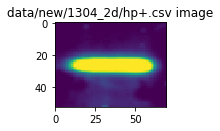

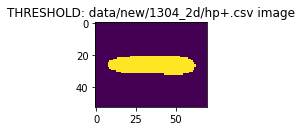

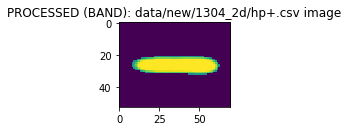

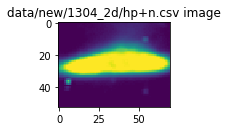

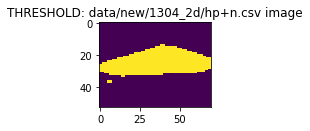

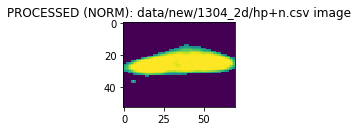

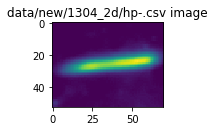

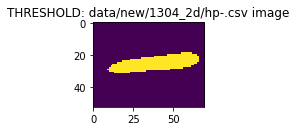

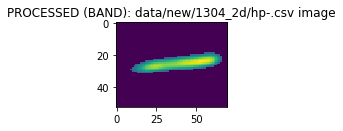

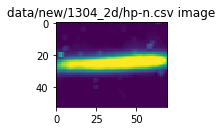

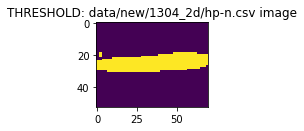

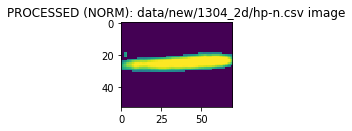

In [50]:
enrichment_analysis('data/new/1304_2d', 'hp', 'hp', threshold = 0.5, hard = True, method = 1)

Background avg: 2.404848484848485 for data/new/1304_2d/h+.csv
Foreground avg: 13.55 for data/new/1304_2d/h+.csv
Background avg: 19.827925270403146 for data/new/1304_2d/h+n.csv
Foreground avg: 219.32734530938123 for data/new/1304_2d/h+n.csv
Magnitude (normalized): 0.006338683997075994
Magnitude (absolute, loading): 99863
Magnitude (absolute): 633
Background avg: 0.6267427122940431 for data/new/1304_2d/h-.csv
Foreground avg: 16.06896551724138 for data/new/1304_2d/h-.csv
Background avg: 13.493243243243244 for data/new/1304_2d/h-n.csv
Foreground avg: 186.37801608579088 for data/new/1304_2d/h-n.csv
Magnitude (normalized): 0.006796584599592516
Magnitude (absolute, loading): 64297
Magnitude (absolute): 437
Enrichment of h: 0.93262783743706


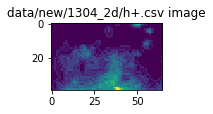

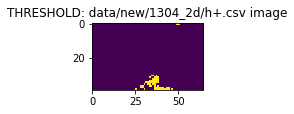

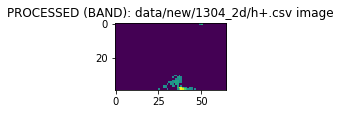

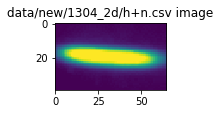

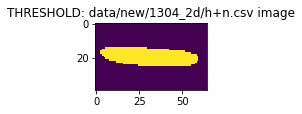

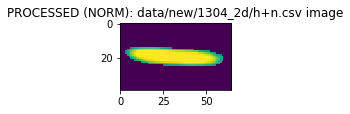

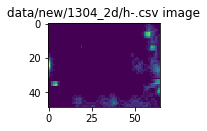

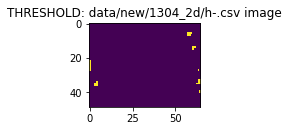

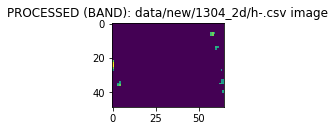

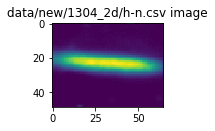

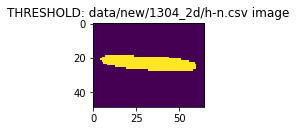

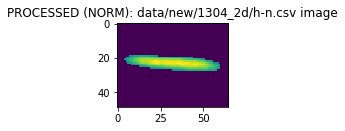

In [53]:
enrichment_analysis('data/new/1304_2d', 'h', 'h', threshold = 0.5, hard = True)

### 18/06 ASSAY
#### Assay Description
Cell line samples (lysate) were thawed from -80 degrees and prepared for a Western. The running was done at 50/100V and blotting at 30 mA overnight. 
#### Notes
- DNA Pol $\Delta$ was used as the loading control.
- WT and C4 were loaded twice.

Background avg: 25.969598262757874 for data/new/1806_2d/c4+.csv
Foreground avg: 138.20806302131604 for data/new/1806_2d/c4+.csv
Background avg: 16.717471756914687 for data/new/1806_2d/c4+n.csv
Foreground avg: 120.32272727272728 for data/new/1806_2d/c4+n.csv
Magnitude (normalized): 1.933495864890232
Magnitude (absolute, loading): 169403
Magnitude (absolute): 327540
Background avg: 17.71782232446051 for data/new/1806_2d/c4-.csv
Foreground avg: 72.88298347476552 for data/new/1806_2d/c4-.csv
Background avg: 18.88903911154032 for data/new/1806_2d/c4-n.csv
Foreground avg: 144.67028627838104 for data/new/1806_2d/c4-n.csv
Magnitude (normalized): 0.810634108705781
Magnitude (absolute, loading): 199603
Magnitude (absolute): 161805
Enrichment of c4: 2.385164705167856


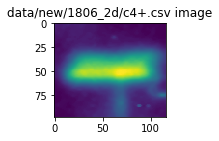

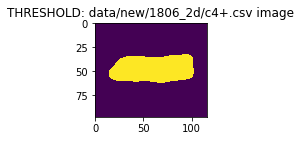

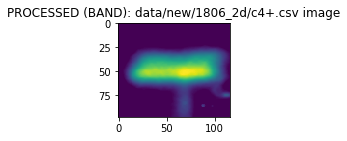

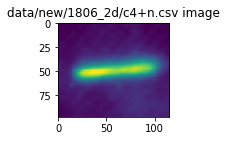

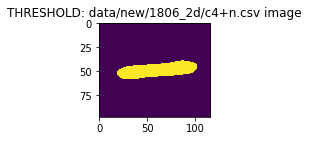

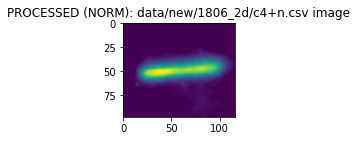

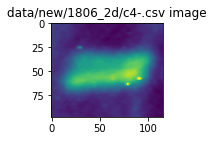

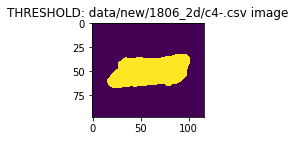

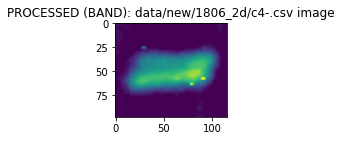

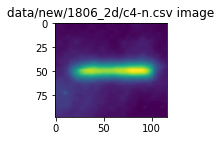

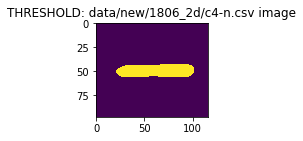

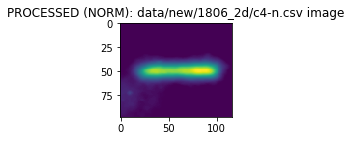

In [54]:
enrichment_analysis('data/new/1806_2d', 'c4', 'c4', threshold = 0.5, hard = False)

Background avg: 11.440730616302186 for data/new/1806_2d/wt+.csv
Foreground avg: 56.2039156626506 for data/new/1806_2d/wt+.csv
Background avg: 5.772856829642622 for data/new/1806_2d/wt+n.csv
Foreground avg: 37.08325912733749 for data/new/1806_2d/wt+n.csv
Magnitude (normalized): 1.9519242389286224
Magnitude (absolute, loading): 91023
Magnitude (absolute): 177670
Background avg: 0.39268591816255993 for data/new/1806_2d/wt-.csv
Foreground avg: 10.093789078782827 for data/new/1806_2d/wt-.csv
Background avg: 3.4801757612916413 for data/new/1806_2d/wt-n.csv
Foreground avg: 45.30910240202276 for data/new/1806_2d/wt-n.csv
Magnitude (normalized): 0.2895046603247814
Magnitude (absolute, loading): 83256
Magnitude (absolute): 24103
Enrichment of wt: 6.742289525629232


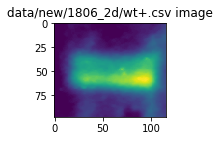

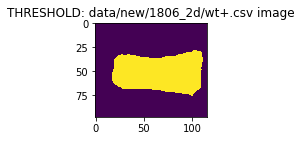

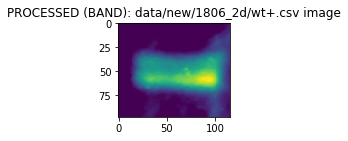

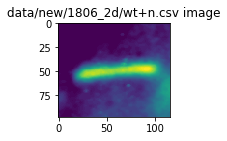

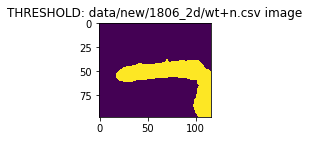

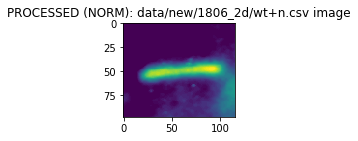

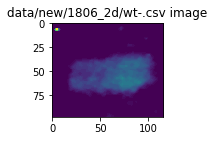

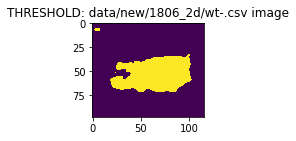

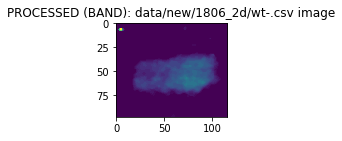

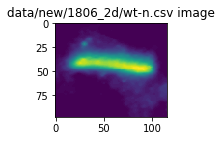

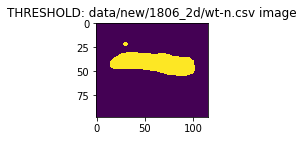

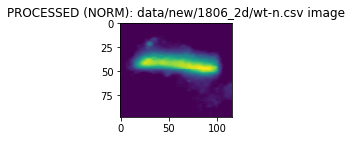

In [55]:
enrichment_analysis('data/new/1806_2d', 'wt', 'wt', threshold = 0.5, hard = False, method = 1)

Background avg: 9.455691554467565 for data/new/1806_2d/hp+.csv
Foreground avg: 41.245465916197624 for data/new/1806_2d/hp+.csv
Background avg: 9.400259584664537 for data/new/1806_2d/hp+n.csv
Foreground avg: 62.22115384615385 for data/new/1806_2d/hp+n.csv
Magnitude (normalized): 1.2210776624336828
Magnitude (absolute, loading): 100087
Magnitude (absolute): 122214
Background avg: 7.0558906312826695 for data/new/1806_2d/hp-.csv
Foreground avg: 28.78363313909298 for data/new/1806_2d/hp-.csv
Background avg: 5.013575119035559 for data/new/1806_2d/hp-n.csv
Foreground avg: 68.09352037408149 for data/new/1806_2d/hp-n.csv
Magnitude (normalized): 0.860318948528965
Magnitude (absolute, loading): 115191
Magnitude (absolute): 99101
Enrichment of hp: 1.4193313590518597


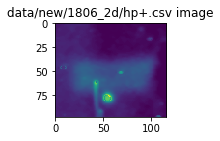

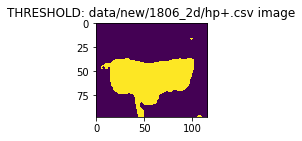

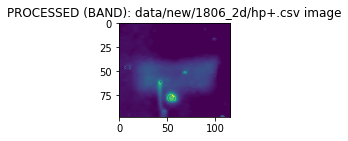

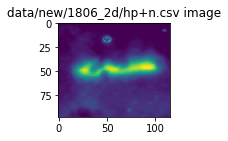

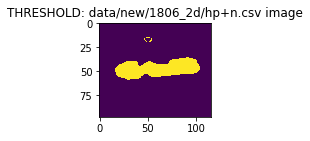

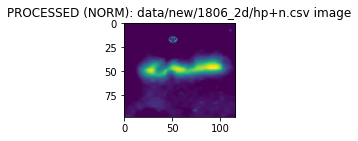

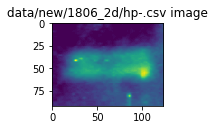

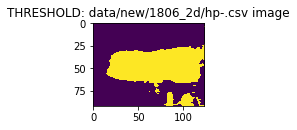

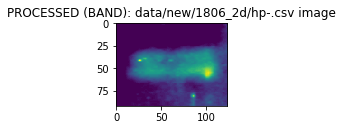

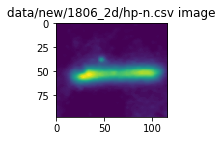

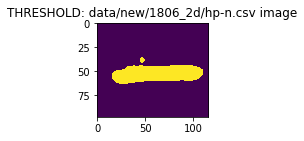

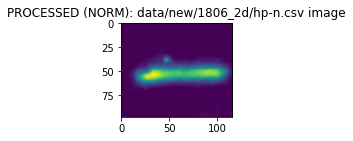

In [56]:
enrichment_analysis('data/new/1806_2d', 'hp', 'hp', threshold = 0.5, hard = False, method = 1)

Background avg: 0.8462130372650324 for data/new/1806_2d/h+.csv
Foreground avg: 10.581682078379568 for data/new/1806_2d/h+.csv
Background avg: 6.985966319165998 for data/new/1806_2d/h+n.csv
Foreground avg: 54.36925287356322 for data/new/1806_2d/h+n.csv
Magnitude (normalized): 0.271557113283732
Magnitude (absolute, loading): 97578
Magnitude (absolute): 26498
Background avg: 0.6943258084197681 for data/new/1806_2d/h-.csv
Foreground avg: 8.57561929595828 for data/new/1806_2d/h-.csv
Background avg: 5.118287014143013 for data/new/1806_2d/h-n.csv
Foreground avg: 57.80429594272076 for data/new/1806_2d/h-n.csv
Magnitude (normalized): 0.17397020157756354
Magnitude (absolute, loading): 88998
Magnitude (absolute): 15483
Enrichment of h: 1.560940384164928


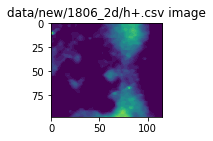

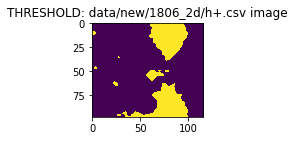

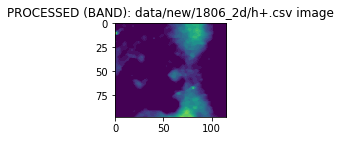

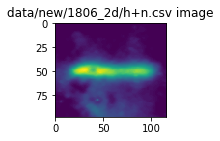

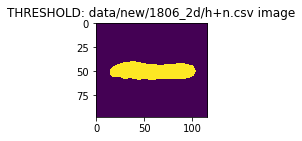

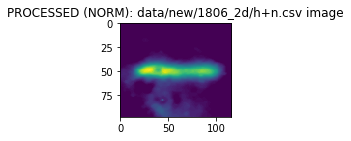

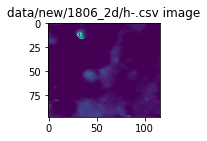

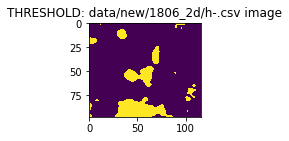

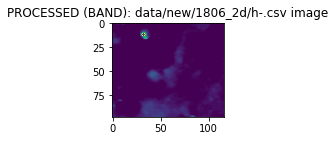

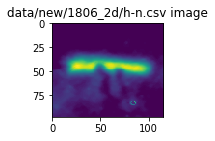

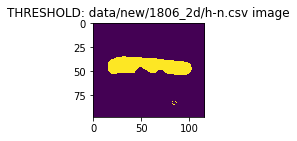

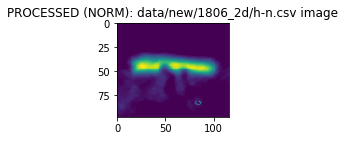

In [57]:
enrichment_analysis('data/new/1806_2d', 'h', 'h', threshold = 0.5, hard = False, method = 1)

Background avg: 4.932243732148525 for data/new/1806_2d/_wt+.csv
Foreground avg: 51.56677087985708 for data/new/1806_2d/_wt+.csv
Background avg: 3.50781019746537 for data/new/1806_2d/_wt+n.csv
Foreground avg: 36.13204373423044 for data/new/1806_2d/_wt+n.csv
Magnitude (normalized): 2.1679430579331473
Magnitude (absolute, loading): 55495
Magnitude (absolute): 120310
Background avg: 4.070711356243812 for data/new/1806_2d/_wt-.csv
Foreground avg: 39.07823129251701 for data/new/1806_2d/_wt-.csv
Background avg: 3.5461196243203164 for data/new/1806_2d/_wt-n.csv
Foreground avg: 44.201117318435756 for data/new/1806_2d/_wt-n.csv
Magnitude (normalized): 0.9239832763207906
Magnitude (absolute, loading): 68406
Magnitude (absolute): 63206
Enrichment of _wt: 2.346301186928059


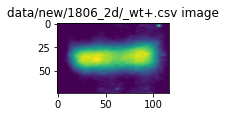

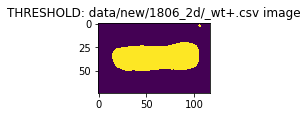

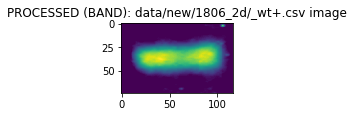

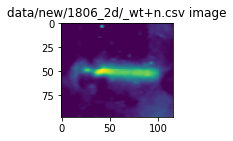

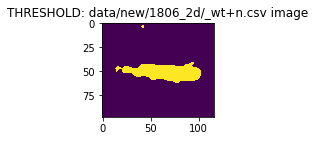

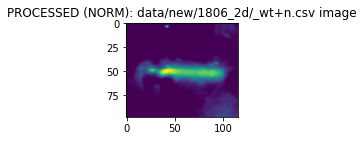

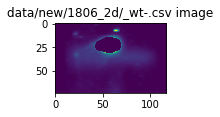

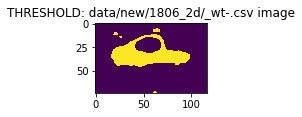

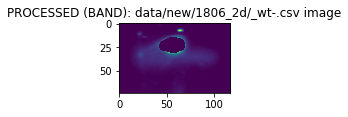

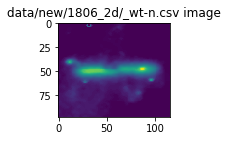

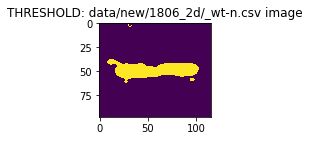

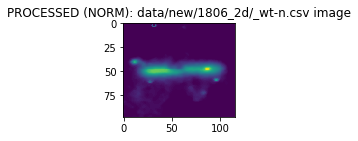

In [59]:
enrichment_analysis('data/new/1806_2d', '_wt', '_wt', threshold = 0.5, hard = False, method = 1)

Background avg: 17.097519729425027 for data/new/1806_2d/_c4+.csv
Foreground avg: 106.54054054054055 for data/new/1806_2d/_c4+.csv
Background avg: 6.342607802874744 for data/new/1806_2d/_c4+n.csv
Foreground avg: 87.31818181818181 for data/new/1806_2d/_c4+n.csv
Magnitude (normalized): 2.0157296586770985
Magnitude (absolute, loading): 158999
Magnitude (absolute): 320499
Background avg: 4.46667638909144 for data/new/1806_2d/_c4-.csv
Foreground avg: 55.7583135391924 for data/new/1806_2d/_c4-.csv
Background avg: 3.009196980096088 for data/new/1806_2d/_c4-n.csv
Foreground avg: 53.294585987261144 for data/new/1806_2d/_c4-n.csv
Magnitude (normalized): 1.361807327144097
Magnitude (absolute, loading): 76046
Magnitude (absolute): 103560
Enrichment of _c4: 1.4801871149455257


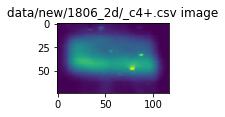

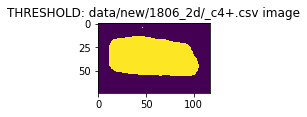

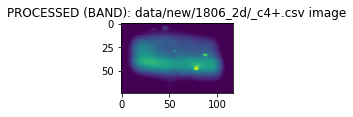

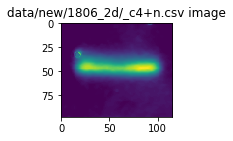

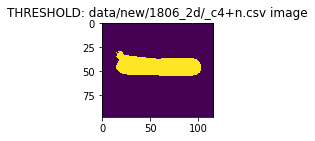

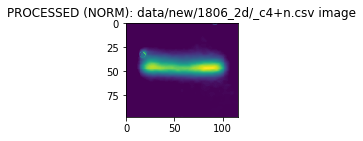

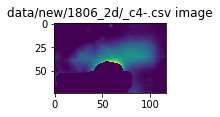

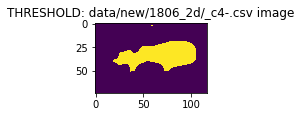

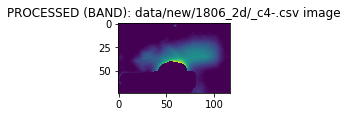

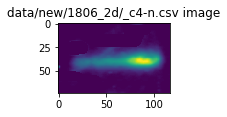

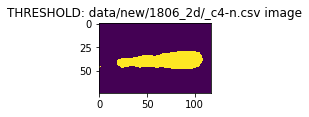

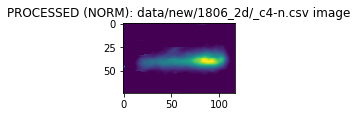

In [58]:
enrichment_analysis('data/new/1806_2d', '_c4', '_c4', threshold = 0.5, hard = False, method = 1)

---

Background avg: 6.257420091324201 for data/new/1304_2d_ar/c4+.csv
Foreground avg: 192.83861185983827 for data/new/1304_2d_ar/c4+.csv
Background avg: 40.148017275225754 for data/new/1304_2d_ar/c4+n.csv
Foreground avg: 238.37145313843507 for data/new/1304_2d_ar/c4+n.csv
Magnitude (normalized): 2.363152463201347
Magnitude (absolute, loading): 257754
Magnitude (absolute): 609112
Background avg: 33.83429263859436 for data/new/1304_2d_ar/c4-.csv
Foreground avg: 185.31262327416172 for data/new/1304_2d_ar/c4-.csv
Background avg: 34.62678260869565 for data/new/1304_2d_ar/c4-n.csv
Foreground avg: 229.92814371257484 for data/new/1304_2d_ar/c4-n.csv
Magnitude (normalized): 2.2591204478188134
Magnitude (absolute, loading): 186504
Magnitude (absolute): 421335
Enrichment of c4: 1.0460497869792542


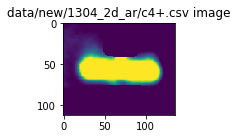

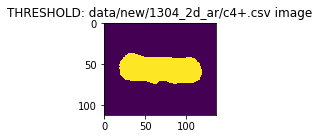

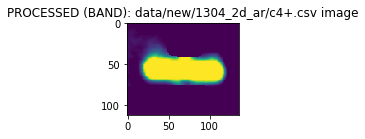

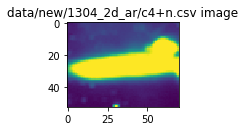

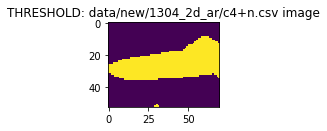

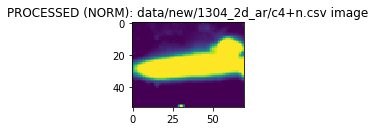

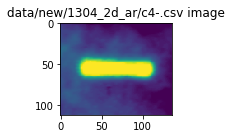

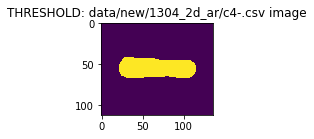

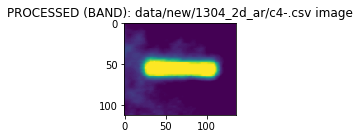

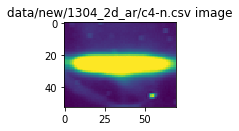

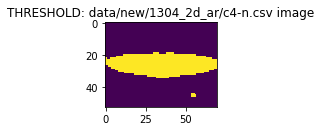

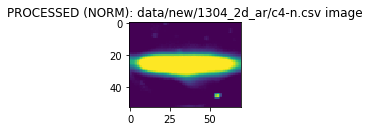

In [7]:
enrichment_analysis('data/new/1304_2d_ar', 'c4', 'c4', threshold = 0.5, hard = False, method = 1)

Background avg: 48.71584967320261 for data/new/1304_2d_ar/wt+.csv
Foreground avg: 191.30882352941177 for data/new/1304_2d_ar/wt+.csv
Background avg: 20.554213135068153 for data/new/1304_2d_ar/wt+n.csv
Foreground avg: 108.24896265560166 for data/new/1304_2d_ar/wt+n.csv
Magnitude (normalized): 8.812149189529455
Magnitude (absolute, loading): 57189
Magnitude (absolute): 503958
Background avg: 26.623659808751086 for data/new/1304_2d_ar/wt-.csv
Foreground avg: 166.13725490196077 for data/new/1304_2d_ar/wt-.csv
Background avg: 23.807333547764554 for data/new/1304_2d_ar/wt-n.csv
Foreground avg: 217.4242928452579 for data/new/1304_2d_ar/wt-n.csv
Magnitude (normalized): 1.8964246195916468
Magnitude (absolute, loading): 141887
Magnitude (absolute): 269078
Enrichment of wt: 4.646717353536022


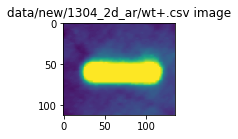

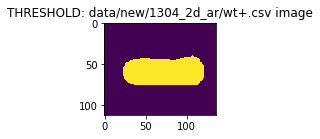

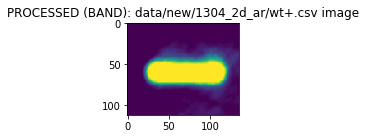

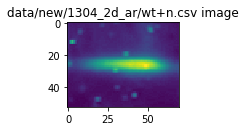

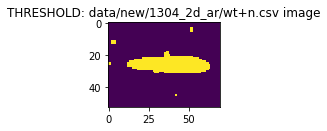

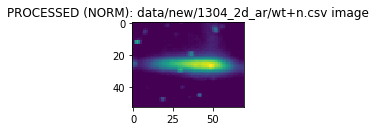

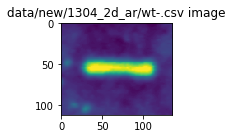

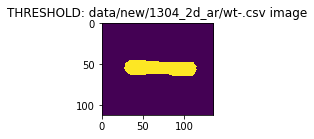

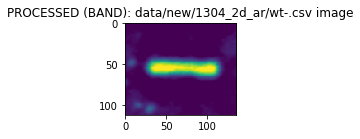

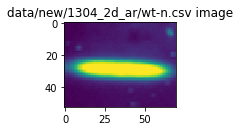

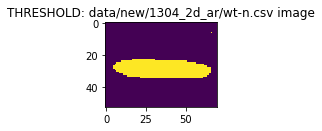

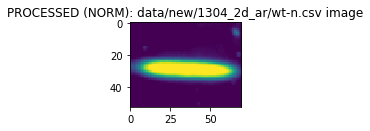

In [8]:
enrichment_analysis('data/new/1304_2d_ar', 'wt', 'wt', threshold = 0.5, hard = False, method = 1)

Background avg: 11.632328050469303 for data/new/1304_2d_ar/hp+.csv
Foreground avg: 69.69247985675918 for data/new/1304_2d_ar/hp+.csv
Background avg: 17.162589928057553 for data/new/1304_2d_ar/hp+n.csv
Foreground avg: 225.6720430107527 for data/new/1304_2d_ar/hp+n.csv
Magnitude (normalized): 0.8816052964976092
Magnitude (absolute, loading): 220221
Magnitude (absolute): 194148
Background avg: 15.077552552552552 for data/new/1304_2d_ar/hp-.csv
Foreground avg: 177.9571129707113 for data/new/1304_2d_ar/hp-.csv
Background avg: 9.838678010471204 for data/new/1304_2d_ar/hp-n.csv
Foreground avg: 209.43119266055047 for data/new/1304_2d_ar/hp-n.csv
Magnitude (normalized): 2.6186899355792588
Magnitude (absolute, loading): 151504
Magnitude (absolute): 396742
Enrichment of hp: 0.3366589089145434


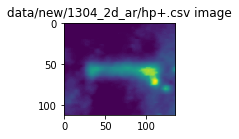

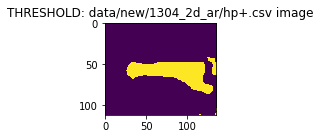

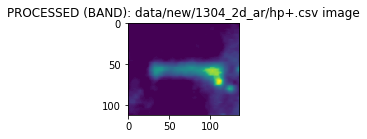

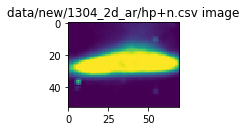

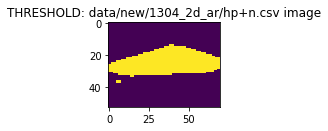

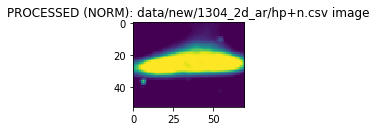

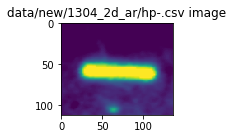

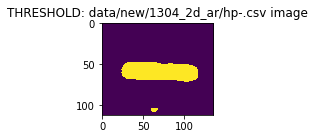

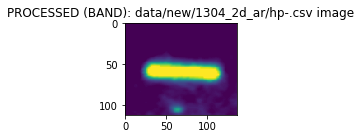

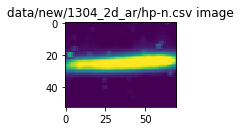

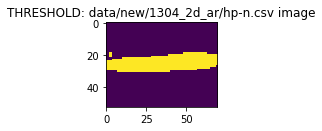

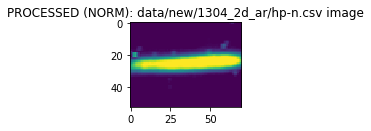

In [9]:
enrichment_analysis('data/new/1304_2d_ar', 'hp', 'hp', threshold = 0.5, hard = False, method = 1)

### 1304 Secondary Diff

Background avg: 17.312940897504298 for data/new/1304_truncation/ar+.csv
Foreground avg: 98.53106852497096 for data/new/1304_truncation/ar+.csv
Magnitude (absolute): 344205.0
Background avg: 22.85297131147541 for data/new/1304_truncation/ar-.csv
Foreground avg: 62.291791090255344 for data/new/1304_truncation/ar-.csv
Magnitude (absolute): 656106.0
Enrichment of ar: 0.5246179733152875


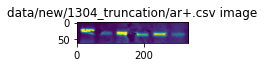

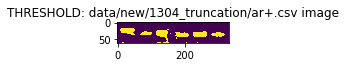

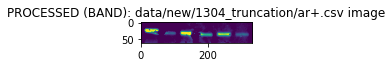

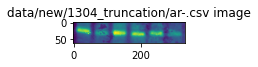

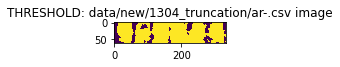

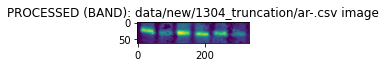

In [12]:
enrichment_analysis('data/new/1304_truncation', 'ar', 'ar', threshold = 0.2, hard = False, method = 0)

### Plotting

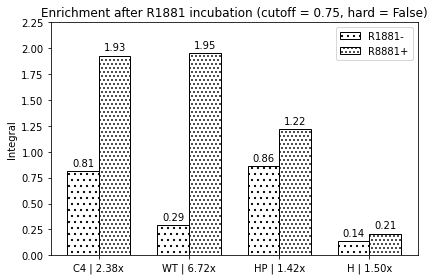

In [7]:
labels = ['C4', 'WT', 'HP', 'H']

r1881_pos = [1.93, 1.95, 1.22, 0.21]
r1881_neg = [0.81, 0.29, 0.86, 0.14]

gain = ['{0:.2f}'.format(p/n) for p,n in zip(r1881_pos, r1881_neg)]
labels = [label + ' | ' + str(g) + 'x' for label, g in zip(labels, gain)]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(2,2)
rect1 = ax.bar(x - width/2, r1881_neg, width, label = 'R1881-', fill = False, hatch = '..')
rect2 = ax.bar(x + width/2, r1881_pos, width, label = 'R8881+', fill = False, hatch = '...')

ax.set_ylabel('Integral')
ax.set_title('Enrichment after R1881 incubation (cutoff = 0.75, hard = False)')
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rect1, padding = 3)
ax.bar_label(rect2, padding = 3)

fig.tight_layout()
plt.ylim([0, 2.25])

plt.show()

#### **24/06/22 ANALYSIS**

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[1.34748577 2.2859052  1.2877337  1.29411765]


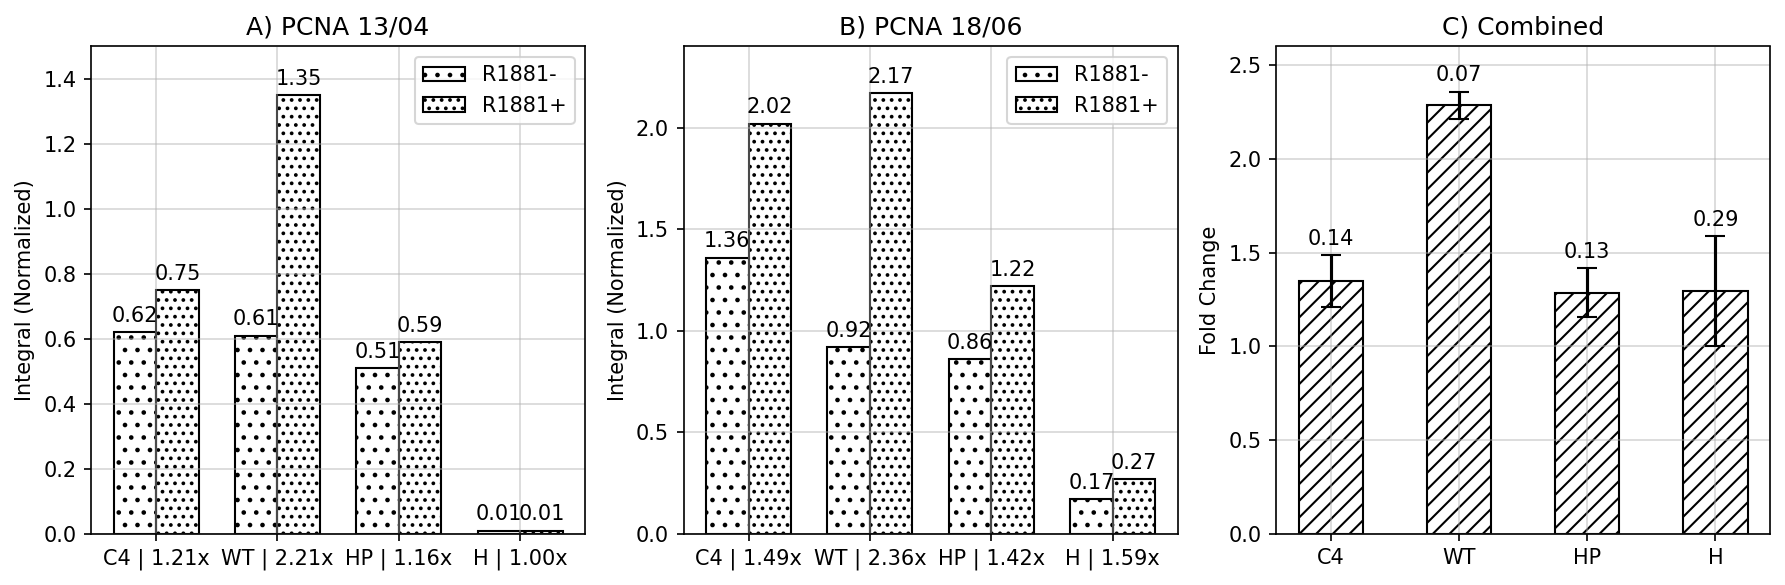

In [89]:
labels = ['C4', 'WT', 'HP', 'H']

# 13/04 data
_1304_r1881_pos = [0.75, 1.35, 0.59, 0.01]
_1304_r1881_neg = [0.62, 0.61, 0.51, 0.01]

_1304_gain = ['{0:.2f}'.format(p/n) for p,n in zip(_1304_r1881_pos, _1304_r1881_neg)]
_1304_labels = [label + ' | ' + str(g) + 'x' for label, g in zip(labels, _1304_gain)]

_1304_x = np.arange(len(_1304_labels))
width = 0.35

# 18/06 data
_1806_r1881_pos = [2.02, 2.17, 1.22, 0.27]
_1806_r1881_neg = [1.36, 0.92, 0.86, 0.17]

_1806_gain = ['{0:.2f}'.format(p/n) for p,n in zip(_1806_r1881_pos, _1806_r1881_neg)]
_1806_labels = [label + ' | ' + str(g) + 'x' for label, g in zip(labels, _1806_gain)]

_1806_x = np.arange(len(_1806_labels))

# Combined data
_1304_gain = np.divide(_1304_r1881_pos, _1304_r1881_neg)
_1806_gain = np.divide(_1806_r1881_pos, _1806_r1881_neg)

combi_gain = np.array([_1304_gain, _1806_gain])
combi_means = np.mean(combi_gain, axis = 0)
combi_stds = np.std(combi_gain, axis = 0)

# ----- Plotting -----
fig, axs = plt.subplots(1, 3)
fig.set_size_inches(12,4)
fig.set_dpi(150)

# -- 1304 -- 
# Bars
_1304_rect_1 = axs[0].bar(x - width/2, _1304_r1881_neg, width, label = 'R1881-', fill = False, hatch = '..')
_1304_rect_2 = axs[0].bar(x + width/2, _1304_r1881_pos, width, label = 'R1881+', fill = False, hatch = '...')

# Numbers on bars
axs[0].bar_label(_1304_rect_1, padding = 3)
axs[0].bar_label(_1304_rect_2, padding = 3)

axs[0].set_title('A) PCNA 13/04')
axs[0].set_ylabel('Integral (Normalized)')
axs[0].set_xticks(_1304_x, _1304_labels)
axs[0].legend()

# -- 1806 -- 
# Bars
_1806_rect_1 = axs[1].bar(x - width/2, _1806_r1881_neg, width, label = 'R1881-', fill = False, hatch = '..')
_1806_rect_2 = axs[1].bar(x + width/2, _1806_r1881_pos, width, label = 'R1881+', fill = False, hatch = '...')

# Numbers on bars
axs[1].bar_label(_1806_rect_1, padding = 3)
axs[1].bar_label(_1806_rect_2, padding = 3)

axs[1].set_title('B) PCNA 18/06')
axs[1].set_ylabel('Integral (Normalized)')
axs[1].set_xticks(_1806_x, _1806_labels)
axs[1].legend()

# -- Combined -- 
bar_combi = axs[2].bar(labels, combi_means, yerr = combi_stds, width = 0.5, capsize = 5, fill = False, hatch = '///')

axs[2].set_title('C) Combined')
axs[2].set_ylabel('Fold Change')

ddds = np.around(combi_stds, 2)
axs[2].bar_label(bar_combi, labels = ddds, padding = 3)

# -- Distance --
print(combi_means)

fig.tight_layout()

axs[0].grid(True, alpha = 0.5)
axs[0].set_ylim(0, 1.5)
axs[1].grid(True, alpha = 0.5)
axs[1].set_ylim(0, 2.4)
axs[2].grid(True, alpha = 0.5)
axs[2].set_ylim(0, 2.6)

plt.savefig('enrichment_results_240622.eps', format = 'eps')
plt.show()

In [78]:
combi_stds[1]

0.0727904490377762

#### **06/07/22 Analysis**

Background avg: 24.531237564663748 for data/new/0607_2d/c4+.csv
Foreground avg: 191.42424242424244 for data/new/0607_2d/c4+.csv
Background avg: 15.5256 for data/new/0607_2d/c4+n.csv
Foreground avg: 117.95275590551181 for data/new/0607_2d/c4+n.csv
Magnitude (normalized): 1.6595088161209068
Magnitude (absolute, loading): 63520
Magnitude (absolute): 105412
Background avg: 21.088565022421523 for data/new/0607_2d/c4-.csv
Foreground avg: 187.16538461538462 for data/new/0607_2d/c4-.csv
Background avg: 22.594087095485417 for data/new/0607_2d/c4-n.csv
Foreground avg: 189.61782178217823 for data/new/0607_2d/c4-n.csv
Magnitude (normalized): 1.0117558489691916
Magnitude (absolute, loading): 103608
Magnitude (absolute): 104826
Enrichment of c4: 1.6402265604015693


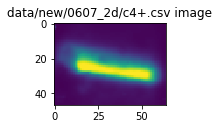

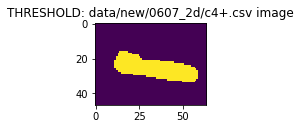

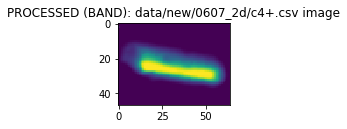

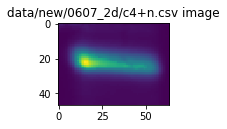

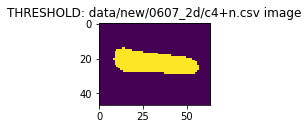

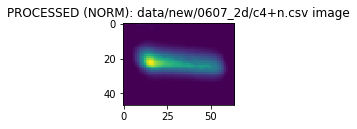

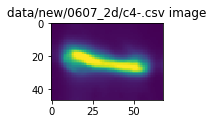

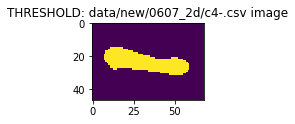

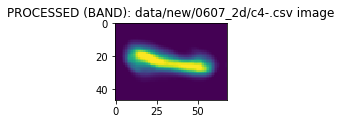

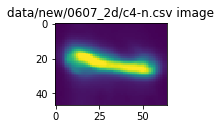

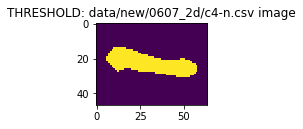

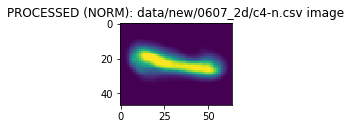

In [7]:
enrichment_analysis('data/new/0607_2d', 'c4', 'c4', threshold = 0.5, hard = False, method = 1)

Background avg: 21.759164367363027 for data/new/0607_2d/wt+.csv
Foreground avg: 209.47983014861995 for data/new/0607_2d/wt+.csv
Background avg: 14.580963665086887 for data/new/0607_2d/wt+n.csv
Foreground avg: 135.68067226890756 for data/new/0607_2d/wt+n.csv
Magnitude (normalized): 1.523277520484503
Magnitude (absolute, loading): 70175
Magnitude (absolute): 106896
Background avg: 20.947014630288653 for data/new/0607_2d/wt-.csv
Foreground avg: 187.70563674321502 for data/new/0607_2d/wt-.csv
Background avg: 18.069204152249135 for data/new/0607_2d/wt-n.csv
Foreground avg: 175.08599508599508 for data/new/0607_2d/wt-n.csv
Magnitude (normalized): 1.2265794934620096
Magnitude (absolute, loading): 79994
Magnitude (absolute): 98119
Enrichment of wt: 1.2418905815758146


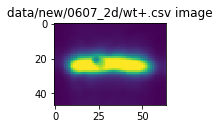

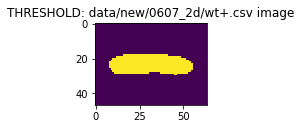

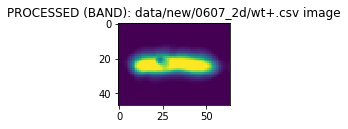

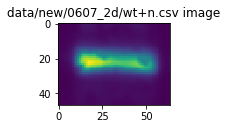

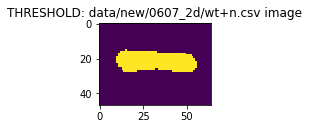

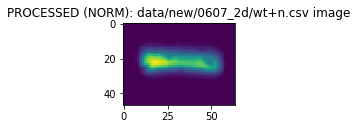

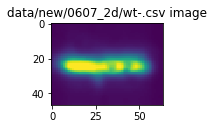

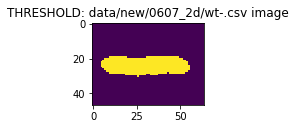

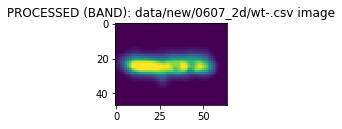

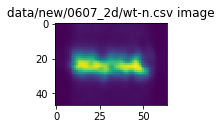

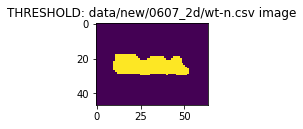

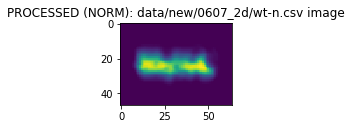

In [8]:
enrichment_analysis('data/new/0607_2d', 'wt', 'wt', threshold = 0.5, hard = False, method = 1)

Background avg: 23.80088141025641 for data/new/0607_2d/a+.csv
Foreground avg: 177.578125 for data/new/0607_2d/a+.csv
Background avg: 14.811667971808927 for data/new/0607_2d/a+n.csv
Foreground avg: 132.83700440528634 for data/new/0607_2d/a+n.csv
Magnitude (normalized): 1.5075395143220494
Magnitude (absolute, loading): 66052
Magnitude (absolute): 99576
Background avg: 25.6769109535067 for data/new/0607_2d/a-.csv
Foreground avg: 207.81063829787234 for data/new/0607_2d/a-.csv
Background avg: 11.920819935691318 for data/new/0607_2d/a-n.csv
Foreground avg: 95.06923076923077 for data/new/0607_2d/a-n.csv
Magnitude (normalized): 2.0605794052968736
Magnitude (absolute, loading): 52295
Magnitude (absolute): 107758
Enrichment of a: 0.7316095222765044


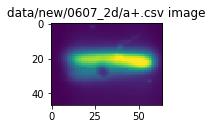

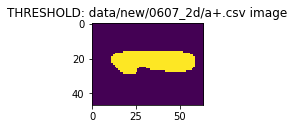

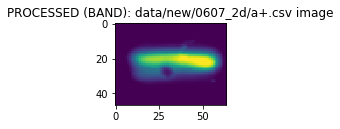

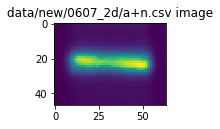

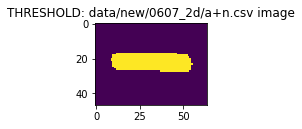

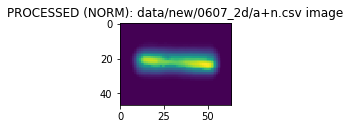

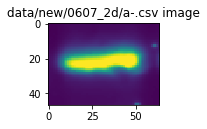

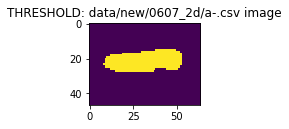

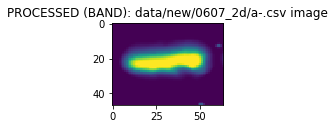

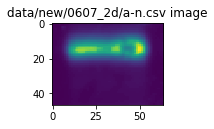

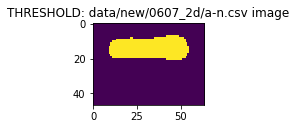

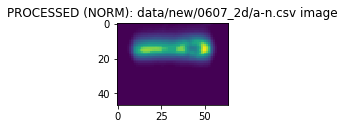

In [9]:
enrichment_analysis('data/new/0607_2d', 'a', 'a', threshold = 0.5, hard = False, method = 1)